# Instructions

For the given dataset, please do the following:


1. Correlation between two continuous variables

2. Correlation between two categorical variables

3. Replace null values with mean or mode

4. Variable transformation (logarithmic transformation)

5. Outlier detection for continuous variables

6. Multicollinearity

In [1]:
!pip install statsmodels

# Setup

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_csv("Insurance_multiple_regression.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


- **age:** quantitative discrete

- **sex:** qualitative binary

- **bmi:** quantitative continuous

- **children:** quantitative discrete

- **smoker:** qualitative binary

- **region:** qualitative nominal

- **charges:** quantitative continuous

In [4]:
import pandas as pd

# Assuming you have a DataFrame named 'df'
data_types = df.dtypes
print(data_types,"\n")

for column, dtype in data_types.items():
    if dtype == 'object':
        if df[column].nunique() == 2:
            print(f"Column '{column}' has qualitative data: binary")
        else:
            print(f"Column '{column}' has qualitative data: nominal")
    elif dtype == 'int64':
        print(f"Column '{column}' has quantitative data: discrete")
    elif dtype == 'float64':
        if df[column].nunique() == 2:
            print(f"Column '{column}' has qualitative data: binary")
        else:
            print(f"Column '{column}' has quantitative data: continuous")
    else:
        print(f"Column '{column}' has unknown data type")

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object 

Column 'age' has quantitative data: discrete
Column 'sex' has qualitative data: binary
Column 'bmi' has quantitative data: continuous
Column 'children' has quantitative data: discrete
Column 'smoker' has qualitative data: binary
Column 'region' has qualitative data: nominal
Column 'charges' has quantitative data: continuous


In [5]:
columns = df.columns
categorical_vars = [col for col in columns if df[col].dtype=='object']
numeric_vars = [col for col in columns if df[col].dtype != 'object']
# or like that 
# numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns
# categorical_vars = df.select_dtypes(include=['object']).columns

print(categorical_vars)
print(numeric_vars)

['sex', 'smoker', 'region']
['age', 'bmi', 'children', 'charges']


# Answers

## 1. Correlation between two continuous variables

In [6]:
##### Correlation between bmi and charges 
correlation_continuous = df['bmi'].corr(df['charges'])
print("Correlation between bmi and charges:", correlation_continuous)


Correlation between bmi and charges: 0.19834096883362884


## 2. Correlation between two categorical variables

In [7]:
##### Convert 'sex' and 'smoker' to binary numeric values
# sex_binary = df['sex'].map({'male': 0, 'female': 1})
# smoker_binary = df['smoker'].map({'no': 0, 'yes': 1})
# correlation_categorical = matthews_corrcoef(sex_binary, smoker_binary)
## or with sklearn method
labelencoder = LabelEncoder()
df['sex'] = labelencoder.fit_transform(df['sex'])
df['smoker'] = labelencoder.fit_transform(df['smoker'])
df['region'] = labelencoder.fit_transform(df['region'])

##### Calculate the point-biserial correlation coefficient
correlation_categorical = matthews_corrcoef(df['region'], df['sex'])
print("Point-biserial correlation coefficient between sex and smoker:", correlation_categorical)


Point-biserial correlation coefficient between sex and smoker: -0.0030590584122004477


In [8]:
import scipy.stats as stats
import numpy as np

# Create a contingency table between sex and smoker
contingency_table = pd.crosstab(df['region'], df['smoker'])

# Calculate Cramér's V
def cramers_v(table):
    chi2 = stats.chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramer_v = cramers_v(contingency_table)
print("Cramér's V between sex and smoker:", cramer_v)

Cramér's V between sex and smoker: 0.05698243611684278


## 3. Replace null values with mean or mode

In [9]:
# Randomly select at least one entry as null in each feature
for column in df.columns:
    # Get a random index for null assignment
    random_index = np.random.choice(df.index)
    
    # Assign null value to the randomly selected entry
    df.loc[random_index, column] = np.nan

In [10]:
# Check for null values

print(df.isnull().sum())

age         1
sex         1
bmi         1
children    1
smoker      1
region      1
charges     1
dtype: int64


In [11]:
df.dtypes

age         float64
sex         float64
bmi         float64
children    float64
smoker      float64
region      float64
charges     float64
dtype: object

In [12]:
for col in numeric_vars:
    df[col].fillna(df[col].mean(), inplace=True)
for col in categorical_vars:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [13]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## 4. Variable transformation (logarithmic transformation)

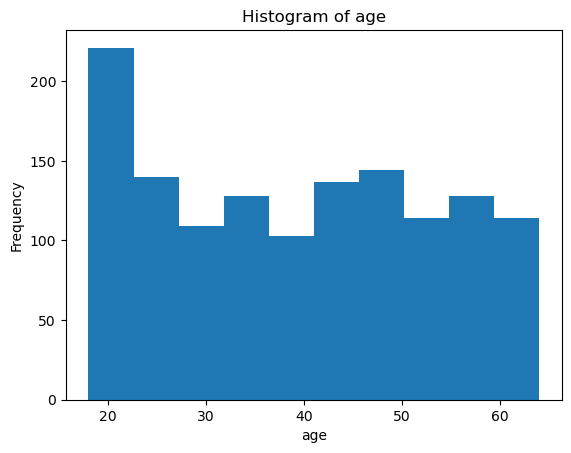

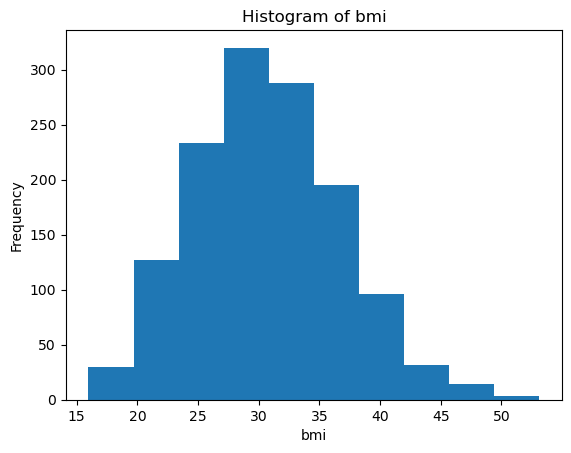

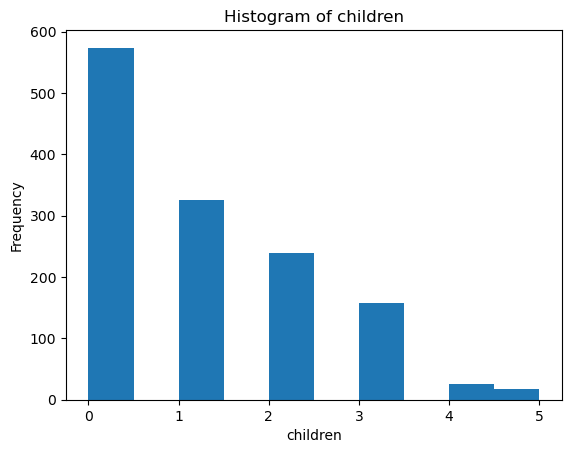

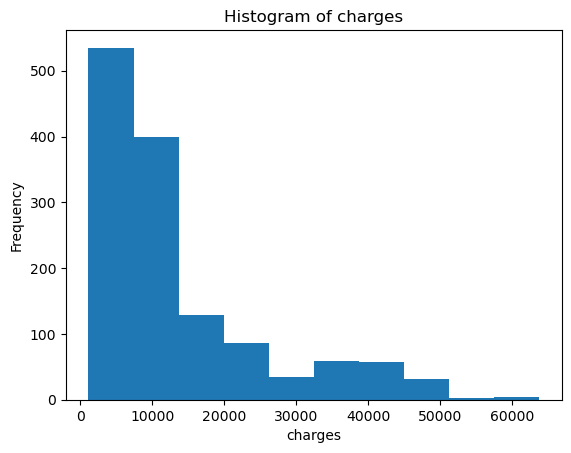

In [14]:
# Plot histograms for numerical variables
for column in numeric_vars:
    plt.figure()
    plt.hist(df[column], bins=10)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [15]:
def detect_right_skew(df, numerical_columns):
    """ Detect right skew for given columns of a given dataframe"""
 
    right_skewed_vars = []

    for column in numerical_columns:
        # Calculate skewness
        skewness = df[column].skew()

        # Check if the skewness is greater than 1 (right-skewed threshold)
        if skewness > 1:
            right_skewed_vars.append(column)

    # Return the list of variables with right-skewed distributions
    return right_skewed_vars

# Detect right-skewed distributions
right_skewed_variables = detect_right_skew(df, numeric_vars)

# Print the variables with right-skewed distributions
print("Variables with right-skewed distributions:")
print(right_skewed_variables)

Variables with right-skewed distributions:
['charges']


In [26]:
# apply logarithmic transformation 
df[right_skewed_variables] = np.log(df[right_skewed_variables])

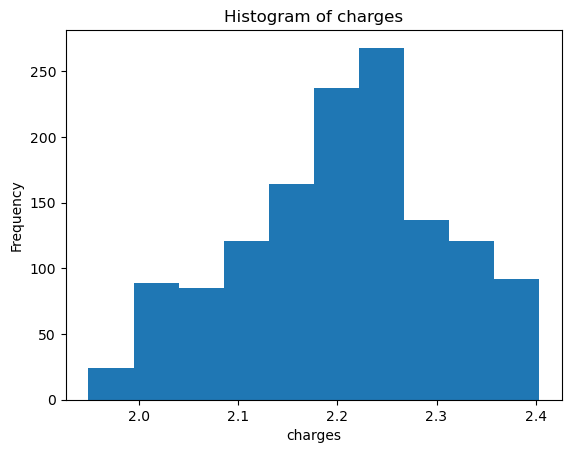

In [27]:
# See result of logarithmic transformation
for column in ['charges']:
    plt.figure()
    plt.hist(df[column], bins=10)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

## 5. Outlier detection for continuous variables

In [18]:
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y = df['charges']

In [19]:
X_cont = X[['bmi']]
Q1 = X_cont.quantile(0.25)
Q3 = X_cont.quantile(0.75)
IQR = Q3 - Q1

outliers = ((X_cont < (Q1 - 1.5 * IQR)) | (X_cont > (Q3 + 1.5 * IQR))).any(axis=1)
num_outliers = outliers.sum()
print(f"Outliers:\n{outliers[outliers==True].index}")

Outliers:
Int64Index([116, 286, 401, 543, 847, 860, 1047, 1088, 1317], dtype='int64')


## 6. Multicollinearity

In [20]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,7.557548,age
1,2.003563,sex
2,10.363879,bmi
3,1.800277,children
4,1.256622,smoker
5,2.923616,region


## 7. Scatter-plots

The code sns.lmplot(data=df, x='age', y='charges', hue="smoker", col="sex") uses the seaborn library (often imported as sns) to create a scatter plot with a linear regression line fit for a given DataFrame df.

Here's what each parameter in the lmplot function represents:

- data=df: Specifies the DataFrame df from which the data for the plot will be extracted.

- x='age': Specifies the column name 'age' from the DataFrame df to be plotted on the x-axis.

- y='charges': Specifies the column name 'charges' from the DataFrame df to be plotted on the y-axis.

- hue="smoker": This parameter adds color differentiation to the plot based on the values in the 'smoker' column. In this case, it will create separate data points and regression lines for smokers and non-smokers.

- col="sex": This parameter creates separate subplots for each unique value in the 'sex' column. In this case, it will generate separate plots for males and females, each with their own data points and regression lines

Overall, the lmplot function creates a scatter plot where the x-axis represents the 'age' column, the y-axis represents the 'charges' column, and the points are differentiated by color based on the 'smoker' column. Additionally, it generates separate subplots for each unique value in the 'sex' column, creating a grid of plots. Each subplot will have its own set of data points and regression line, allowing for comparison and analysis across different categorie

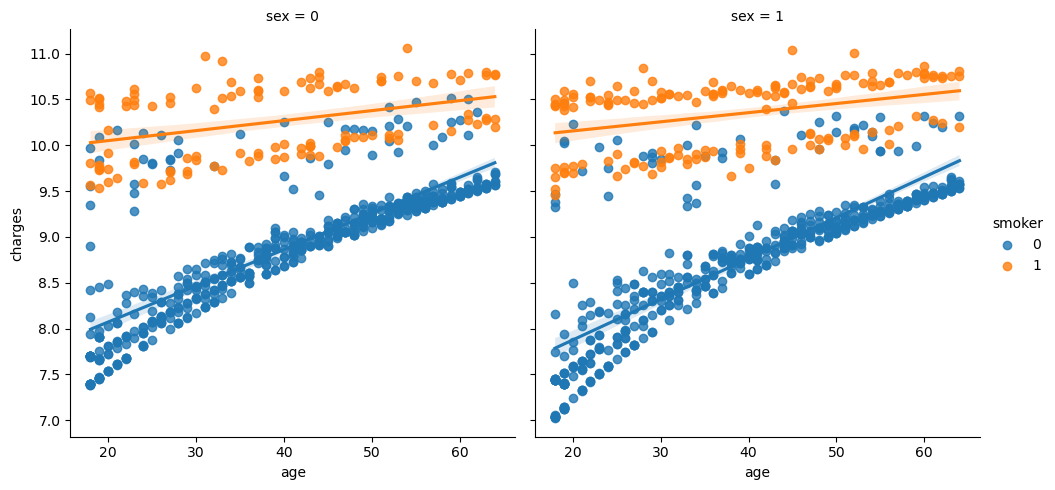

In [39]:
sns.lmplot(data=df, x='age', y='charges', hue="smoker", col="sex") 

Text(0.5, 1.0, 'age > 40')

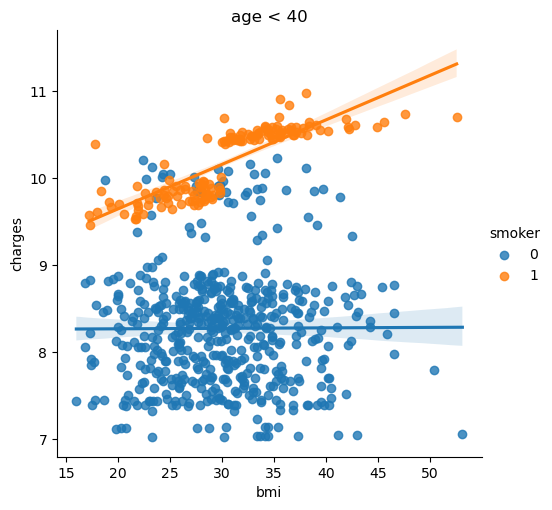

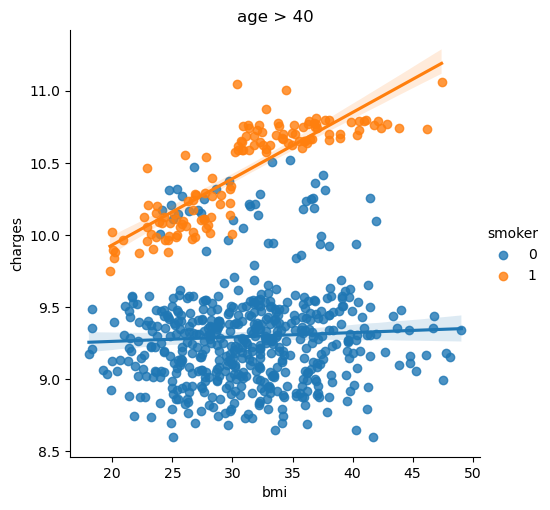

In [46]:
df1, df2 = df.loc[df['age']<40], df.loc[df['age']>=40]

lm1 = sns.lmplot(data=df1, x='bmi', y='charges', hue="smoker")
ax1 = lm1.axes
ax1 = plt.gca()
ax1.set_title('age < 40')


lm2 = sns.lmplot(data=df2, x='bmi', y='charges', hue="smoker")
ax2 = lm2.axes
ax2 = plt.gca()
ax2.set_title('age > 40')

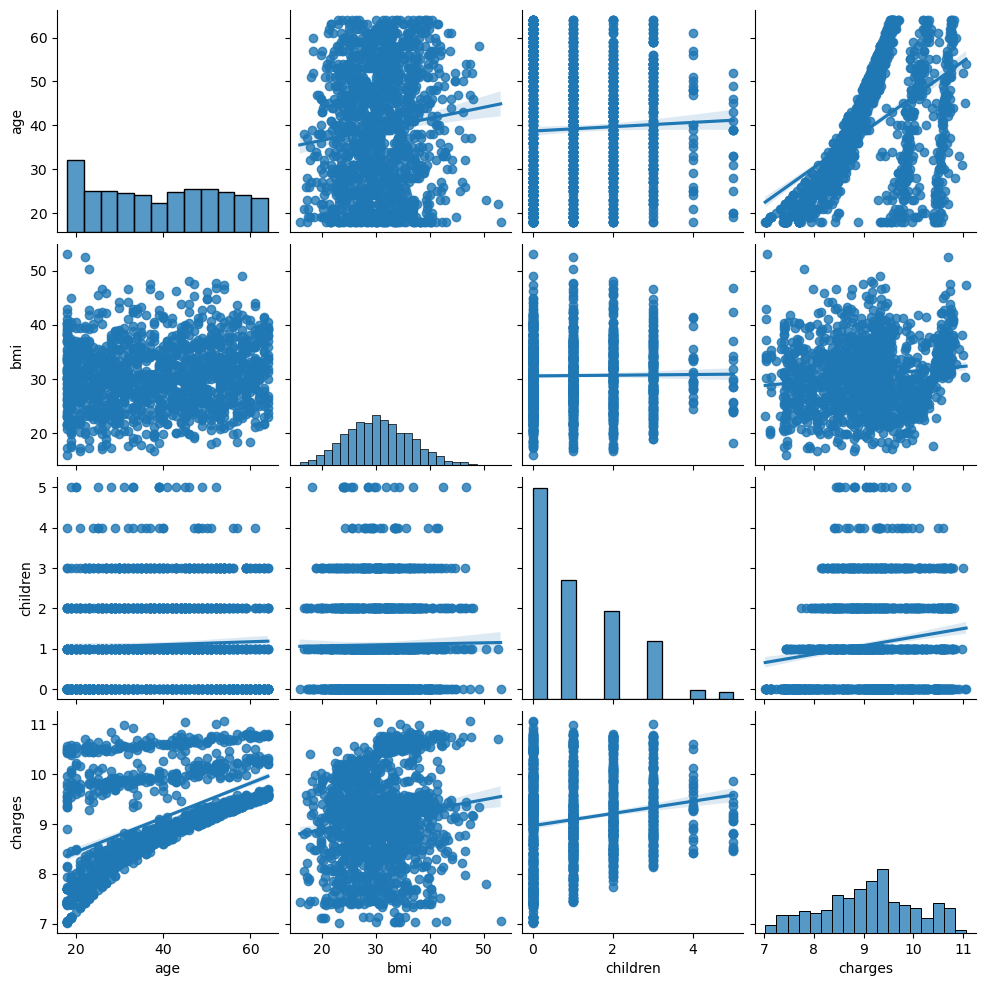

In [52]:
# Looking at scatter plots between y and each variables in a single visual
sns.pairplot(data=df[['age', 'bmi','children','charges']], kind='reg')
plt.show()

## 8. Categorical & Continuous

In [63]:
from numpy import sqrt, abs, round 
from scipy.stats import norm

def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2): 
    ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1-X2)/ovr_sigma
    pval = 2*(1-norm.cdf(abs(z)))
    return z, pval

def z_test():
    z_data = df[['smoker','charges']]
    d1 = z_data[(z_data['smoker']==1)]['charges']
    d2 = z_data[(z_data['smoker']==0)]['charges']
    print(d1.head())
    m1, m2 = d1.mean(), d2.mean()
    sd1, sd2 = d1.std(), d2.std()
    n1, n2 = d1.shape[0], d2.shape[0]

    z, p = TwoSampZ(X1=m1, X2=m2, sigma1=sd1, sigma2=sd2, N1=n1, N2=n2)

    z_score = round(z, 8)
    p_val = round(p, 6)

    if (p_val<0.05):
        hyp_status = 'Reject null hypothesis'
    else:
        hyp_status = 'Do not reject null hypothesis'

    print(hyp_status)
    
    return z_score, p_val

In [62]:
z_test()

0      9.734176
11    10.233105
14    10.586881
19    10.514271
23    10.537465
Name: charges, dtype: float64
Reject null hypothesis


(46.37084369, 0.0)